## Authors EDA
Exploratory data analysis focused on authors.

In [211]:
import pandas as pd
from matplotlib import pyplot as plt 
import numpy as np

%matplotlib inline

In [212]:
%%time

# load metadata extracted data in notebook 00_load_metadata
# parse the author_parsed entries into a list of authors for each paper
arxiv_metadata = pd.read_csv('data/arxiv_metadata.zip', converters={"authors_parsed": lambda x:[entry.strip('[]') for entry in  x.split("], ")]})

<timed exec>:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 14.9 s, sys: 919 ms, total: 15.9 s
Wall time: 15.9 s


In [213]:
def flatten(xss):
    return [x for xs in xss for x in xs]

def get_authors(df):
    """Given a dataframe, return unique authors"""
    authors = flatten(df['authors_parsed'])
    return set(authors)

def count_authors(df):
    """Given a dataframe, return count of unique authors"""
    return len(get_authors(df))

In [175]:
# ALL AUTHORS
all_authors = get_authors(arxiv_metadata)

# PUBLISHED AUTHORS
idx = arxiv_metadata['journal-ref'].isna()
arxiv_published = arxiv_metadata[~idx]
published_authors = get_authors(arxiv_published)

pd.DataFrame.from_dict(
    {'All authors': len(all_authors), 'Published authors': len(published_authors)}, orient='index', columns=["Count"])

,Count
All authors,1918203
Published authors,881061


### Authors by subject

In [146]:
keys = ["Computer Science", "Economics", "Electrical Engineering and Systems Science", "Mathematics", "Physics", "Quantitative Biology", "Quantitative Finance", "Statistics", "Junk"]

In [176]:
# total papers submitted, by subject
counts_total = {key:count_authors(arxiv_metadata[arxiv_metadata[key]==1]) for key in keys if key in arxiv_metadata.keys()}
counts_total_df = pd.DataFrame.from_dict(counts_total, orient='index', columns=["Count"])
counts_total_df['Subject'] = counts_total_df.index

# papers published, by subject
counts_published = {key:count_authors(arxiv_published[arxiv_published[key]==1]) for key in keys if key in arxiv_published.keys()}
counts_published_df = pd.DataFrame.from_dict(counts_published, orient='index', columns=["Count"])
counts_published_df['Subject'] = counts_published_df.index

# merge both into 1 dataframe
counts_df = counts_total_df.join(counts_published_df, on="Subject", how='left', lsuffix='_left', rsuffix='_right')
counts_df = counts_df.drop(['Subject', 'Subject_left', 'Subject_right'], axis=1)
counts_df.rename(columns={'Count_left':'All authors', 'Count_right':'Published authors'}, inplace=True)
counts_df.sort_values('Published authors', ascending=False, inplace=True)
counts_df

,All authors,Published authors
Physics,1072227,629407
Computer Science,983756,347178
Mathematics,306731,106396
Statistics,139837,32216
Quantitative Biology,94642,28707
Electrical Engineering and Systems Science,141277,25873
Quantitative Finance,24053,5525
Economics,13603,2051
Junk,3501,647


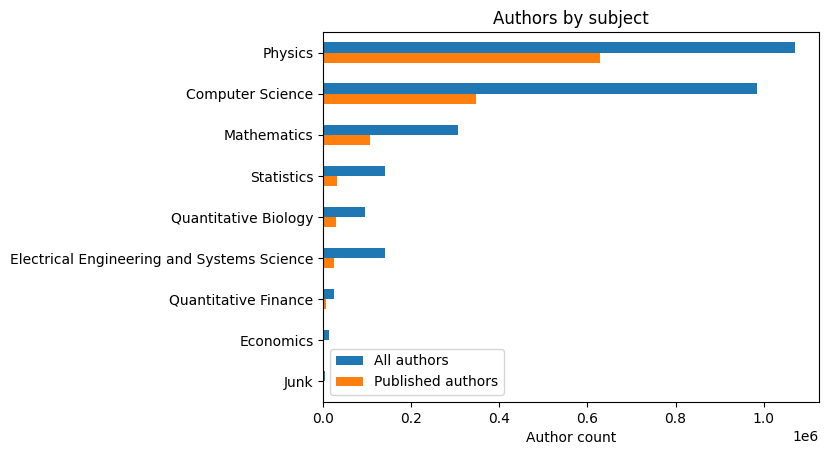

In [193]:
pp_subject = counts_df.sort_values('Published authors', ascending=False)
bar_plot = pp_subject.plot.barh()
bar_plot.set_title('Authors by subject')
bar_plot.set_xlabel('Author count')
bar_plot.invert_yaxis()
plt.show();

### Published authors over time

#### Cumulative number of authors 

In [214]:
# keep only papers 1992 - 2023, as older years are incomplete
min_year = 1992  # arxiv_metadata.year.min()
max_year = 2023  # arxiv_metadata.year.max()

In [215]:
# PUBLISHED
arxiv_published = arxiv_published[(arxiv_published['year'] >= min_year)]
arxiv_published = arxiv_published[(arxiv_published['year'] <= max_year)]

# SUBMITTED (ALL PAPERS)
arxiv_metadata = arxiv_metadata[(arxiv_metadata['year'] >= min_year)]
arxiv_metadata = arxiv_metadata[(arxiv_metadata['year'] <= max_year)]

In [257]:
# AUTHORS PUBLISHED
counts_published = pd.DataFrame(columns=['year', 'month', 'count'])
year = []; month = []; authors_count = []
for entry in arxiv_published.groupby([arxiv_published.year, arxiv_published.month]):
    entry_year = entry[0][0]
    year.append(entry_year)
    entry_month = entry[0][1]
    month.append(entry_month)
    authors_count.append(len(set(flatten(arxiv_published[(arxiv_published['month']==entry_month) & (arxiv_published['year']==entry_year)]['authors_parsed']))))
counts_published['year'] = year
counts_published['month'] = month
counts_published['count'] = authors_count

# ALL AUTHORS
counts_all = pd.DataFrame(columns=['year', 'month', 'count'])
year = []; month = []; authors_count = []
for entry in arxiv_metadata.groupby([arxiv_metadata.year, arxiv_metadata.month]):
    entry_year = entry[0][0]
    year.append(entry_year)
    entry_month = entry[0][1]
    month.append(entry_month)
    authors_count.append(len(set(flatten(arxiv_metadata[(arxiv_metadata['month']==entry_month) & (arxiv_metadata['year']==entry_year)]['authors_parsed']))))
counts_all['year'] = year
counts_all['month'] = month
counts_all['count'] = authors_count

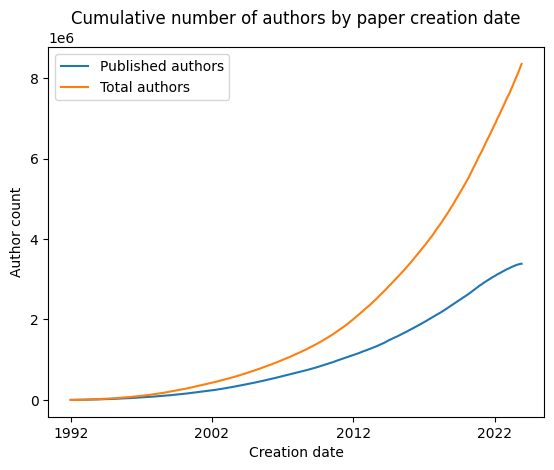

In [259]:
plt.title('Cumulative number of authors by paper creation date')
plt.xticks(ticks=range(0, len(counts_published), 120), labels=range(min_year, max_year+1, 10))
plt.xlabel('Creation date')
plt.ylabel('Author count')
plt.plot(np.cumsum(list(counts_published['count'])), label='Published authors')
plt.plot(np.cumsum(list(counts_all['count'])), label='Total authors')
plt.legend()
plt.show();

### Monthly number of authors by paper creation date

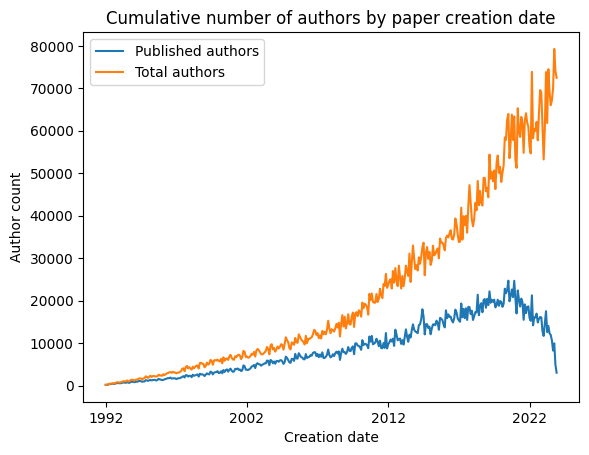

In [260]:
plt.title('Cumulative number of authors by paper creation date')
plt.xticks(ticks=range(0, len(counts_published), 120), labels=range(min_year, max_year+1, 10))
plt.xlabel('Creation date')
plt.ylabel('Author count')
plt.plot(list(counts_published['count']), label='Published authors')
plt.plot(list(counts_all['count']), label='Total authors')
plt.legend()
plt.show();